In [2]:
# data wrangling
import pandas as pd
import numpy as np

# object serialization
import pickle

# GPU acceleration
from numba import jit, cuda

#Timer
from timeit import default_timer as timer 

# ML Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm 

# ML metrics
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score

# Data Splitting
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


In [3]:
# read in data
df = pd.read_csv("C:\\Users\\conor\\OneDrive\\Desktop\\school\\Data Science Minor Independent Study\\chest-xray-research\\datasets\\chest_xray_train.csv")

# get all pixel columns
selected_features = list(df.columns)
selected_features.remove("file_name")
selected_features.remove("class_id")

# Set train and target
X = df[selected_features]
y = df['class_id']



In [5]:
# Get random split data, only do this once, model should not make data any different
model = svm.SVC()
cross_val = cross_validate(estimator=model,
                           X=X,
                           y=y,
                           cv=10,
                           n_jobs = -1,
                           return_train_score = True,
                           return_estimator = True,
                           return_indices = True)



In [6]:
cross_val

{'fit_time': array([100.14761162, 101.63639379, 101.05589199, 100.31025195,
        101.09142327, 102.26593113, 102.0292325 , 100.53844976,
        102.11680269, 101.55932355]),
 'score_time': array([12.35962558, 11.70055628, 11.74660683, 11.95577693, 11.81015325,
        11.68054223, 11.59196305, 11.90373302, 11.59396958, 11.65552044]),
 'estimator': [SVC(),
  SVC(),
  SVC(),
  SVC(),
  SVC(),
  SVC(),
  SVC(),
  SVC(),
  SVC(),
  SVC()],
 'indices': {'train': (array([ 442,  445,  450, ..., 4669, 4670, 4671]),
   array([   0,    1,    2, ..., 4669, 4670, 4671]),
   array([   0,    1,    2, ..., 4669, 4670, 4671]),
   array([   0,    1,    2, ..., 4669, 4670, 4671]),
   array([   0,    1,    2, ..., 4669, 4670, 4671]),
   array([   0,    1,    2, ..., 4669, 4670, 4671]),
   array([   0,    1,    2, ..., 4669, 4670, 4671]),
   array([   0,    1,    2, ..., 4669, 4670, 4671]),
   array([   0,    1,    2, ..., 4669, 4670, 4671]),
   array([   0,    1,    2, ..., 4231, 4235, 4236])),
  'te

In [8]:
import random
index = random.randint(0,10)
print(index)

3


In [10]:
train_data = cross_val['indices']['train'][3]
test_data = cross_val['indices']['test'][3]

In [14]:
len(train_data)

4205

In [13]:
len(test_data)

467

In [31]:
# Save indices
with open('static_data/train.pickle','wb') as handle:
    pickle.dump(train_data, handle)

with open('static_data/test.pickle','wb') as handle:
    pickle.dump(test_data, handle)

In [40]:
# @jit(target_backend='cuda')	
def build_and_eval_cross_validate_model(model, X, y):

    # Load indicies
    with open('static_data/train.pickle','rb') as handle:
        train_indices = pickle.load(handle)

    with open('static_data/test.pickle','rb') as handle:
        test_indices = pickle.load(handle)

    # Get training and test data
    X_train, X_test = X.iloc[train_indices,:], X.iloc[test_indices,:] 
    y_train, y_test = y[train_indices], y[test_indices]

    # Fit data to model
    model.fit(X_train,y_train)

    # Get metrics
    y_pred = model.predict(X_test)
    print(metrics.classification_report(y_test, y_pred))
    acc = accuracy_score(y_pred, y_test) # see scores
    print(acc)
    cm = confusion_matrix(y_test, y_pred, labels = model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
    
    disp.plot()
    
    return cross_val

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       123
           1       0.77      0.89      0.83       224
           2       0.68      0.46      0.55       120

    accuracy                           0.78       467
   macro avg       0.77      0.75      0.75       467
weighted avg       0.77      0.78      0.77       467

0.7815845824411135


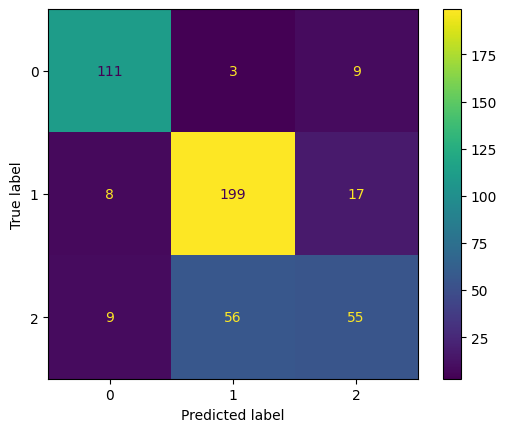

In [41]:
model = svm.SVC()
svm_data = build_and_eval_cross_validate_model(model, X, y)